In [2]:
import seaborn as sn
import pandas as pd
import numpy as np
import geopandas as gp
%matplotlib inline

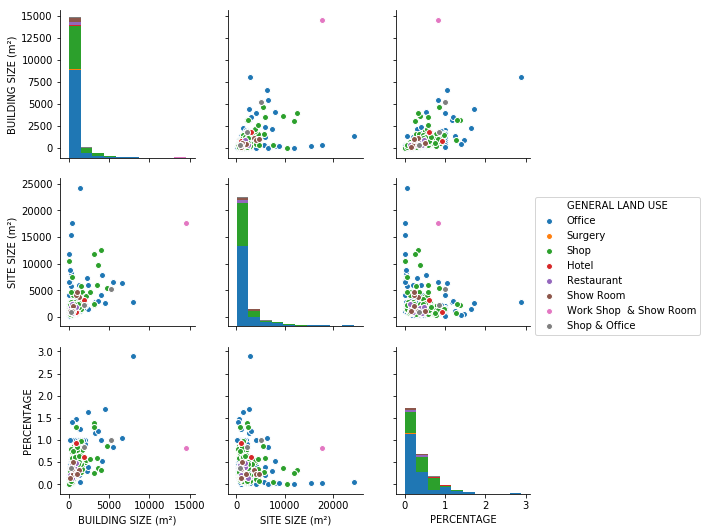

In [3]:
df = pd.read_excel('C:\\Users\\shafeeq.mollagee\\All scenarios.xlsx', sheet_name = 'Existing', header = 1)

df = df.groupby(['ERF NUMBER', 'GENERAL LAND USE']).sum().reset_index().iloc[:,:5]
df['PERCENTAGE'] = df['BUILDING SIZE (m²)'] / df['SITE SIZE (m²)']
df = df[['GENERAL LAND USE','BUILDING SIZE (m²)', 'SITE SIZE (m²)', 'PERCENTAGE']]
df = df.replace([np.inf, -np.inf], np.nan).dropna()
sn.pairplot(df, hue = 'GENERAL LAND USE')

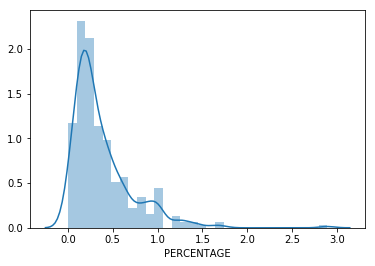

In [4]:
sn.distplot(df['PERCENTAGE'])

In [5]:
existing = pd.read_excel('C:\\Users\\shafeeq.mollagee\\All scenarios.xlsx', sheet_name = 'Existing', header = 1, nrows = 460)
AV_GLA = existing['REALISTIC GLA AT 90%'].sum() / existing['SITE SIZE (m²)'].sum()
existinglu = existing[['ERF NUMBER', 'REALISTIC GLA AT 90%', 'GENERAL LAND USE']]
existing = existing[['ERF NUMBER', 'REALISTIC GLA AT 90%']]

existing.columns = ['ERF NO', 'EX GLA']
existing['ERF NO'] = existing['ERF NO'].astype(str)
existing = existing.groupby('ERF NO').sum().reset_index()

p50 = pd.read_excel('C:\\Users\\shafeeq.mollagee\\All scenarios.xlsx', sheet_name = '50%', header = 1, nrows = 279)
p50 = p50[['Erf_nr', 'POTENTIAL REALISTIC GLA (m²) (1 storey business, 2 storeys flats)', 'POTENTIAL NO OF FLATS (1 storey business, 2 storeys flats)']]
p50.columns = ['ERF NO', '50GLA', '50FLATS']
p50['ERF NO'] = p50['ERF NO'].round(0).astype(str)
p50 = p50.groupby('ERF NO').sum().reset_index()

p100 = pd.read_excel('C:\\Users\\shafeeq.mollagee\\All scenarios.xlsx', sheet_name = '100%', header = 0, nrows = 848)
p100 = p100[['ERF NO', 'POTENTIAL REALISTIC GLA (m²) (1 storey business, 2 storeys flats)', 'POTENTIAL NO OF FLATS (1 storey business, 2 storeys flats)']]
p100.columns = ['ERF NO', '100GLA', '100FLATS']
p100['ERF NO'] = p100['ERF NO'].astype(str)
p100 = p100.groupby('ERF NO').sum().reset_index()

cbdzones=gp.read_file('D:\\001_Projects\\01 - GIPTN\\04 - Macro Model\\Shapefiles\\CBD Study Area Zoning.gpkg')
cbdzones = cbdzones[['ERFNO', 'Zoning', 'geometry', 'Area']]
cbdzones.to_csv('D:\\001_Projects\\01 - GIPTN\\04 - Macro Model\\Land use study\\dl.csv')
cbdzones = cbdzones.dissolve(by = 'ERFNO').reset_index()
cbdzones.columns = ['ERF NO', 'geometry', 'zoning', 'Area']

In [18]:
result = pd.merge(cbdzones, existing[['ERF NO', 'EX GLA']], 
                  on = 'ERF NO', 
                  how='left')
result = pd.merge(result, p50[['ERF NO', '50GLA', '50FLATS']], 
                  on = 'ERF NO', 
                  how='left')
result = pd.merge(result, p100[['ERF NO', '100GLA', '100FLATS']], 
                  on = 'ERF NO', 
                  how='left')

result['EX GLA'] = np.where(result['EX GLA'].isnull(), result['Area']*AV_GLA, result['EX GLA'])
result['50GLA'] = np.where(result['50GLA'].isnull(), 0, result['50GLA'] - result['EX GLA'])
result['50GLA'] = np.where(result['50GLA'] < 0, 0, result['50GLA'])
result['50FLATS'] = np.where(result['50FLATS'].isnull(), 0, result['50FLATS'])
result['100GLA'] = np.where(result['100GLA'].isnull(), 0, result['100GLA'] - result['EX GLA'])
result['100GLA'] = np.where(result['100GLA'] < 0, 0, result['100GLA'])
result['100FLATS'] = np.where(result['100FLATS'].isnull(), 0, result['100FLATS'])
result = result.round(0)

result.to_csv('D:\\001_Projects\\01 - GIPTN\\04 - Macro Model\\Land use study\\gla.csv')

In [20]:
result.crs = {'ellps': 'WGS84',
 'k': 1,
 'lat_0': 0,
 'lon_0': 23,
 'no_defs': True,
 'proj': 'tmerc',
 'towgs84': '0,0,0,0,0,0,0',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}
result.to_file('D:\\001_Projects\\01 - GIPTN\\04 - Macro Model\\Land use study\\gla.shp')

In [17]:
cbdzones.crs

{'ellps': 'WGS84',
 'k': 1,
 'lat_0': 0,
 'lon_0': 23,
 'no_defs': True,
 'proj': 'tmerc',
 'towgs84': '0,0,0,0,0,0,0',
 'units': 'm',
 'wktext': True,
 'x_0': 0,
 'y_0': 0}